In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.integrate as integrate
import astropy.constants as c
import astropy.units as u
import scipy as sp
from astropy.modeling import models
from astropy.cosmology import Planck15 as cosmo

In [2]:
global meKeV; meKeV = 5.109989461e+02


# Radiative transfer integrals
# ------------------------------------------------------------------------
# Standard non-relativistic, thermal relative flux density SZ scaling factor
def gSZ(x):
    factor  = -4.+x*(np.exp(x)+1.)/(np.exp(x)-1.)
    factor *= (x**4.)*np.exp(x)/((np.exp(x)-1.)**2.0)
    return factor

# Generalised form of the relative flux density SZ scaling factor
def gSZtilde(xnu,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'):
    if (Te==0.0):
        factor = gSZ(xnu)
    else:
        if (etype in ['thermal','Thermal']):
            factor  = integrate.dblquad(jszThermal,0.0,np.inf,lambda x: 0.0,lambda x: np.inf,args=(xnu,Te))[0]
            factor -= planckSpectrum(xnu)
            factor *= meKeV/Te
        elif (etype in ['powerlaw','power_law','powerLaw','PowerLaw']):
            factor  = integrate.dblquad(jszPowerLaw,0.0,np.inf,lambda x: 0.0,lambda x: np.inf,args=(xnu,p1,p2,alpha))[0]
            factor -= planckSpectrum(xnu)
            factor *= meKeV/Te
        elif (etype in ['ultrarelativistic','ultra-relativistic','ultrarel','ultraRel']):
            factor  = planckSpectrum(xnu)*meKeV/Te
    return factor

# Thermal electron momentum distribution
def jszThermal(p,t,x,Te):
    electronThermal = ((meKeV/Te)/sp.special.kn(2,(meKeV/Te)))*p*p*np.exp(-(meKeV/Te)*np.sqrt(1.+p*p))
    return redistrFunction(t,p)*planckSpectrum(x/t)*electronThermal

# Non-thermal electron momentum distribution (power-law)
def jszPowerLaw(p,t,x,p1,p2,alpha):
  # Ultra-relativisitc : p1=1, p2=1e3, alpha=2
  # Relativistic       : p1=3, p2=1e3, alpha=2
    electronPowerLaw = (alpha-1.)*(p**(-alpha))/((p1**(1.-alpha))-(p2**(1.-alpha)))
    factor = redistrFunction(t,p)*planckSpectrum(x/t)*electronPowerLaw

    return np.where((p1<p<p2),0.00,factor)

# Planck spectrum
def planckSpectrum(x):
    return (x**3.)/(np.exp(x)-1.)

# Photon redistribution function
def redistrFunction(t,p):
    if (np.abs(np.log(t))>2.*np.arcsinh(p)):
        factor = 0.0
    else:
            factor  = (3.+(3.+p*p)*p*p)/np.sqrt(1.+p*p)
            factor -= (2.*np.arcsinh(p)-np.abs(np.log(t)))*(1.5+p*p)/p
            factor *= 3.*(1.+t)/(8.*(p**5.))
            factor -= (1.+((10.+(8.+4.*p*p)*p*p)+t)*t)*3.*np.abs(1.-t)/(32.*t*(p**6.))
    return factor

#def kT_cr(p1,p2,alpha):
#    factor = integrate.quad(lambda p: f_cr(p, alpha, p1, p2)*1/3*p*p**2/np.sqrt(1+p**2)*meKeV, p1*0.5, 1.5*p2)
#    return factor[0]
    #
    
def kT_cr(p1, p2, alpha):
    beta = sp.special.beta((alpha-2)/2, (3-alpha)/2)
    factor = meKeV*(alpha-1)/(6*(p1**(1-alpha)-p2**(1-alpha)))*\
    (sp.special.betainc((alpha-2)/2, (3-alpha)/2, (1/(1+p1**2)))*beta  \
     -sp.special.betainc((alpha-2)/2, (3-alpha)/2, (1/(1+p2**2)))*beta)
    return factor

In [3]:
#In the below functions, t is the photon frequency shift factor and T is the temperature
#def K(t,p):
#    return -3*np.abs(1-t)/(32*p**6*t)*(1+(10+8*p**2 + 4*p**4)*t+t**2) + \
#(3*(1+t))/(8*p**5)*((3+3*p**2+p**4)/np.sqrt(1+p**2) - (3+2*p**2)/(2*p)*(2*np.arcsinh(p) -np.abs(np.log(t))))

def K(t,p):
    factor = -3*np.abs(1-t)/(32*p**6*t)*(1+(10+8*p**2 + 4*p**4)*t+t**2) + \
             (3*(1+t))/(8*p**5)*((3+3*p**2+p**4)/np.sqrt(1+p**2) - (3+2*p**2)/(2*p)*(2*np.arcsinh(p) -np.abs(np.log(t))))
    return np.where(np.abs(np.log(t))>2.*np.arcsinh(p),0.00,factor)

def K_s(s, p):
    es = np.exp(s)
    return(K(es, p)*es)

def K_int(t, f, **kwargs):
    return integrate.quad(lambda p: f(p, **kwargs)*K(t,p), 0, np.inf)[0]

def _K_1_s(s, f, **kwargs):
    if 'p1' in kwargs.keys():
        p1 = kwargs['p1']
        return integrate.quad(lambda p: f(p, **kwargs)*K_s(s,p), p1, 250*p1, limit = 100000)[0]
    else:
        return integrate.quad(lambda p: f(p, **kwargs)*K_s(s,p), 0, np.inf, limit = 100000)[0]

K_1_s = np.vectorize(_K_1_s, excluded = ['f'], otypes = [np.float])

def _f_cr(p, alpha, p1, p2):
    if p1 < p < p2:
        return (alpha -1)*p**(-1*alpha)/(p1**(1-alpha)-p2**(1-alpha))
    else:
        return 0
    
f_cr = np.vectorize(_f_cr, excluded=['alpha','p1', 'p2'], otypes = [np.float]) 

def f_th(p,T):
    #'T' should be in units of eV
    try:
        T = T.to(u.keV)
    except:
        print('Error: T cannot be converted to eV')
        return
    beta_th = (meKeV/T.value)
    return beta_th/sp.special.kn(2,beta_th)*p**2*np.exp(-1*beta_th*np.sqrt(1+p**2))

 
def planckSpectrum(x):
    return (x**3.)/(np.exp(x)-1.)    
    
#def j(x, f, **kwargs):
#    return integrate.quad(lambda t: i(x/t).value*K_int(t, f, **kwargs), 0, np.inf)

def j(x,f, **kwargs):
    return integrate.dblquad(lambda t, p: planckSpectrum(x/t)*f(p, **kwargs)*K(t,p), 0, np.inf, lambda p: 0, lambda p: np.inf)[0]

def _gTilde(x,f, **kwargs):
    return j(x,f,**kwargs) - planckSpectrum(x)

gTilde = np.vectorize(_gTilde, excluded = ['f'], otypes = [np.float])


# Replicating fig 2 in Enslin 2000

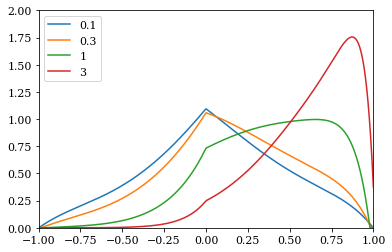

In [81]:
#This replicates the photon scattering probability function, called K(t,P) here and in zubair's paper and P in Enslin 2000
#The plot is of the log freq shift version but also validates K

s_space = np.linspace(-3.6,3.6,10000)
ps = [0.1, 0.3, 1, 3]
s_max_p = [0.2, 0.6, 1.8, 3.6]

for i, p in enumerate(ps):
    x = s_space/s_max_p[i]
    y = K_s(s_space, p)*s_max_p[i]
    plt.plot(x,y, label = str(p))
    
plt.xlim(-1,1)
plt.ylim(0, 2)
plt.legend()
plt.show()

# Replicating Fig 3 in Colafrancesco

<ipython-input-195-327143dc5fb1>:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda p: f(p, **kwargs)*K_s(s,p), p1, 500*p1, limit = 100000)[0]
<ipython-input-195-327143dc5fb1>:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda p: f(p, **kwargs)*K_s(s,p), p1, 500*p1, limit = 100000)[0]
<ipython-input-195-327143dc5fb1>:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda p: f(p, **kwargs)*K_s(s,p), p1, 500*p1, limit = 100000)[0]
<ipython-input-195-327143dc5fb1>:21: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return integrate.quad(lambda p: f(p, **kwargs)*K_s(s,p), p1, 500*p1, limit = 100000)[0]
<ipython-input-195-327143dc5fb1>:21: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may

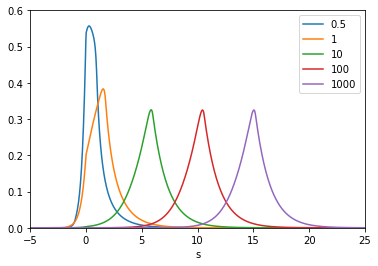

In [197]:
s_space = np.linspace(-5, 25,1000)
ps = [0.5, 1, 10, 100, 1000]

for i, p in enumerate(ps):
    x = s_space
    y = K_1_s(s_space, f_cr, alpha = 2.5, p1=p, p2 = 1e8)
    plt.plot(x,y, label = str(p))
    
plt.ylim(0, 0.6)
plt.xlim(-5,25)
plt.xlabel('s')
plt.legend()
plt.show()

# Replicating Fig.4 is Esslin

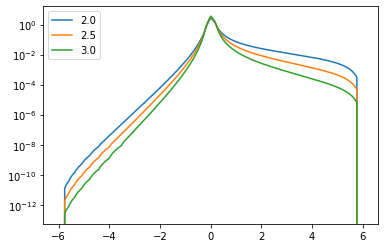

In [200]:
alphas = [2.0, 2.5, 3.0]
s_space = np.linspace(-6,6,1000)
for i, alpha in enumerate(alphas):
    x = s_space
    y = K_1_s(s_space, f_cr, alpha = alpha, p1=0.1, p2 = 10)
    plt.plot(x,y, label = str(alpha))
    
#plt.xlim(-6,6)
#plt.ylim(-14, 0.5)
plt.yscale('log')
plt.legend()
plt.show()
    

# Electron momentum spectrum, non-thermal

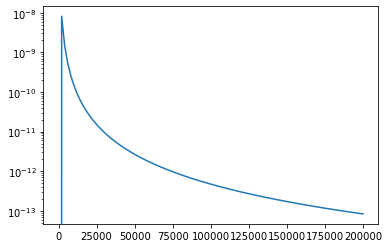

In [7]:
x = np.linspace(0,2e5, 100)
y = f_cr(x, alpha = 2.5, p1 = 1, p2 = 1e8)

plt.plot(x,y)
plt.yscale('log')
plt.show()


# Electron momentum spectrum, thermal

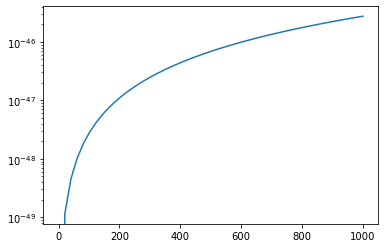

In [8]:
x = np.linspace(0,1e3)
y = f_th(x, 10000*u.eV)

plt.plot(x,y)
plt.yscale('log')
plt.show()

# Plankian dist

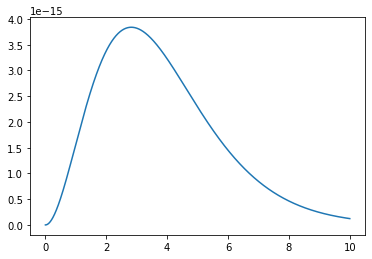

<Quantity 3.77351683e-15 erg / (cm2 Hz s sr)>

In [18]:
x = np.linspace(0.00001,10, 100000)
y =  planckSpectrum(x)

plt.plot(x,y)
plt.show()
planckSpectrum(2.5)

# gSZ thermal

<ipython-input-3-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)
/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


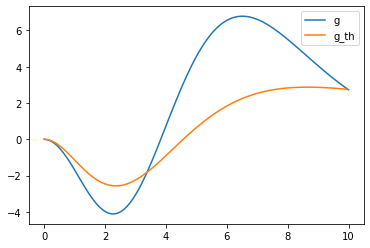

In [12]:
x = np.linspace(0.00001,10, 100)

y = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
y2 = np.zeros(len(x))
for i, ix in enumerate(x):
    y2[i] = gSZtilde(ix,Te=100,p1=1.,p2=1.e3,alpha=2.,etype='thermal')

plt.plot(x,y, label = 'g')
plt.plot(x,y2, label = 'g_th')
plt.legend()
plt.show()

In [7]:
y = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')


# TolTEC Estimates

In [66]:
x = 150*1e9*u.Hz * c.h /(c.k_B*2.7*u.K)
y_no_bub = gSZtilde(x, Te=0.0, p1 = 1., p2 =1.e3, alpha=2, etype='thermal')
y_therm = gSZtilde(x, Te=50, p1 = 1., p2 =1.e3, alpha=2, etype='thermal')

kT_cr_temp = kT_cr(p1=1, p2=1e3, alpha =2.5)

#Powerlaw 
y_cr = gTilde(x.value,f_cr, p1 = 1, p2 = 1e3, alpha = 2)*meKeV/kT_cr_temp

#ultrarel
y_ucr = gSZtilde(x.value,kT_cr_temp, p1 = 3, p2 = 1e3, alpha = 2, etype = 'ultrarelativistic')



<ipython-input-3-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


In [67]:
print('Thermal Ratio, 150', y_therm/y_no_bub)
print('Powerlaw Ratio, 150', y_cr/y_no_bub)
print('Ultra Ratio, 150', y_ucr/y_no_bub)

Thermal Ratio, 150 0.777418933420474
Powerlaw Ratio, 150 0.3035347761462656
Ultra Ratio, 150 -0.4166594679111023


In [68]:
x = 220*1e9*u.Hz * c.h /(c.k_B*2.7*u.K)
y_no_bub = gSZtilde(x, Te=0.0, p1 = 1., p2 =1.e3, alpha=2, etype='thermal')
y_therm = gSZtilde(x, Te=50, p1 = 1., p2 =1.e3, alpha=2, etype='thermal')

kT_cr_temp = kT_cr(p1=1, p2=1e3, alpha =2.5)

#Powerlaw 
y_cr = gTilde(x.value,f_cr, p1 = 1, p2 = 1e3, alpha = 2)*meKeV/kT_cr_temp

#ultrarel
y_ucr = gSZtilde(x.value,kT_cr_temp, p1 = 3, p2 = 1e3, alpha = 2, etype = 'ultrarelativistic')

<ipython-input-3-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


In [69]:
print('Thermal Ratio, 220', y_therm/y_no_bub)
print('Powerlaw Ratio, 220', y_cr/y_no_bub)
print('Ultra Ratio, 220', y_ucr/y_no_bub)

Thermal Ratio, 220 -2.190030720477631
Powerlaw Ratio, 220 -2.3796422081918016
Ultra Ratio, 220 3.9778158162158213


In [71]:
x = 270*1e9*u.Hz * c.h /(c.k_B*2.7*u.K)
y_no_bub = gSZtilde(x, Te=0.0, p1 = 1., p2 =1.e3, alpha=2, etype='thermal')
y_therm = gSZtilde(x, Te=50, p1 = 1., p2 =1.e3, alpha=2, etype='thermal')

kT_cr_temp = kT_cr(p1=1, p2=1e3, alpha =2.5)

#Powerlaw 
y_cr = gTilde(x.value,f_cr, p1 = 1, p2 = 1e3, alpha = 2)*meKeV/kT_cr_temp

#ultrarel
y_ucr = gSZtilde(x.value,kT_cr_temp, p1 = 3, p2 = 1e3, alpha = 2, etype = 'ultrarelativistic')

<ipython-input-3-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


In [72]:
print('Thermal Ratio, 270', y_therm/y_no_bub)
print('Powerlaw Ratio, 270', y_cr/y_no_bub)
print('Ultra Ratio, 270', y_ucr/y_no_bub)

Thermal Ratio, 220 0.31991673968483336
Powerlaw Ratio, 220 -0.10865712610197076
Ultra Ratio, 220 0.2625622680181104


# f plot

## 90 GHz

In [4]:
x = 0.5284*90/30

n = 100

Ts = np.logspace(0,3, n)
ps = np.logspace(-1,2, n)
f_th_arr_mustang = np.zeros(len(Ts))
f_cr_arr_mustang = np.zeros(len(Ts))
g = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
for i, T in enumerate(Ts):
    #kT_cr_temp = kT_cr(p1=ps[i], p2=1e5, alpha =2.5)
    f_th_arr_mustang[i] = gSZtilde(x,Te=T,p1=1.,p2=1.e3,alpha=2.,etype='thermal')/g
    #f_cr_arr_mustang[i] = gTilde(x,f_cr, p1 = ps[i], p2 = 1e10, alpha = 6)*meKeV/kT_cr(p1=ps[i], p2=1e10, alpha =2.5)/g
    



/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
<ipython-input-3-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)
/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/local/jupyter2021/lib/python3.8/site-packages/scipy

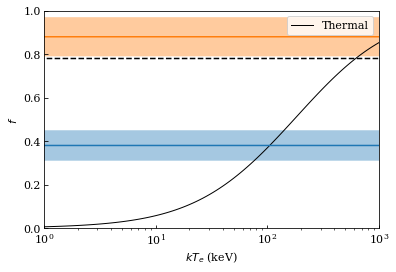

In [10]:
interp_vals = np.logspace(0,3, 100000)

#non_thermal_interp = np.interp(interp_vals, Ts, 1-f_cr_arr_mustang)
def conv(x):
    #string = r'${:.0e}$'.format(int(x/1e1))
    num = int(np.log10(x/10))
    string = r'$10^{'+str(num)+'}$'
    return string

import matplotlib
matplotlib.rc('font',**{'family':'serif','sans-serif':['Times'],'size':11})
plt.rc('font',family='serif',size=11)
fullpage = False


dpi = 72.27*390.00/504.00

factory = 0.50
factorx = 1.00 if fullpage else 0.50
figsize = (factorx*504.00/dpi,factory*504.00/dpi)

fig, ax = plt.subplots()
plt.plot(Ts, 1-f_th_arr_mustang, "k", lw=1, label="Thermal")
#plt.plot(interp_vals, non_thermal_interp, '--k', lw=1, label='Non-thermal')

ax.legend()
ax.tick_params(direction='in')
ax.set_xlabel(r"$kT_e$ (keV)"), ax.set_ylabel(r"$f$")
ax.set_xlim(1,1e3), ax.set_ylim(0, 1), ax.set_xscale('log')

ax.spines['right'].set_visible(True)
#ax.spines['top'].set_visible(True)
props = dict(boxstyle='round',  alpha=0.2)


#ax2 = ax.twiny()
#ax2.set_xscale('log')
#ax2.set_xticks( ax.get_xticks() )
#ax2.set_xbound(ax.get_xbound())
#ax2.set_xticklabels([conv(x) for x in ax.get_xticks()])
#ax2.set_xlabel(r'$p1 (p2 = 10^5, s = 6)$')


xs = np.logspace(-2,4,10000)
ax.plot(xs, np.ones(len(xs))*0.38)
ax.fill_between(xs, 0.31,0.45, alpha = 0.4)

ax.plot(xs, np.ones(len(xs))*0.88)
ax.fill_between(xs, 0.79,0.97, alpha = 0.4)

ax.plot(xs, np.ones(len(xs))*0.78, color='black', linestyle='--')
#ax.fill_between(xs, 0.78,1, alpha = 0.4)

plt.savefig('f_plot_2.pdf')
#plt.savefig('./plots/herschel/v0_fixed_greybody_for_paper.png', dpi = 300)
plt.show()

In [58]:
x = 0.5284*30/30

n = 20

Ts = np.logspace(0,3, n)
ps = np.logspace(-1,2, n)
f_th_arr_carma = np.zeros(len(Ts))
f_cr_arr_carma = np.zeros(len(Ts))
g = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
for i, T in enumerate(Ts):
    #kT_cr_temp = kT_cr(p1=ps[i], p2=1e5, alpha =2.5)
    f_th_arr_carma[i] = gSZtilde(x,Te=T,p1=1.,p2=1.e3,alpha=2.,etype='thermal')/g
    f_cr_arr_carma[i] = gTilde(x,f_cr, p1 = ps[i], p2 = 1e10, alpha = 2.5)*meKeV/kT_cr(p1=ps[i], p2=1e10, alpha =2.5)/g
    



<ipython-input-53-85887fc90c5a>:45: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


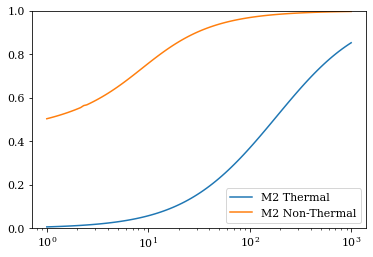

In [8]:
adjust_factor = 1

plt.plot(Ts, 1-f_th_arr_mustang, label = 'M2 Thermal')
plt.plot(Ts, 1-(f_cr_arr_mustang)/adjust_factor, label = 'M2 Non-Thermal')

#plt.plot(Ts, 1-f_th_arr_carma, label = 'CA Thermal')
#plt.plot(Ts, 1-(f_cr_arr_carma)/adjust_factor, label = 'CA Non-Thermal')

plt.legend()
plt.xscale('log')
plt.ylim(0,1)
plt.show()

## f150

In [48]:
x = 0.5284*90/30

n = 100

Ts = np.logspace(0,3, n)
ps = np.logspace(-1,2, n)
f_th_arr_mustang = np.zeros(len(Ts))
f_cr_arr_mustang = np.zeros(len(Ts))
g = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
for i, T in enumerate(Ts):
    #kT_cr_temp = kT_cr(p1=ps[i], p2=1e5, alpha =2.5)
    f_th_arr_mustang[i] = gSZtilde(x,Te=T,p1=1.,p2=1.e3,alpha=2.,etype='thermal')/g
    f_cr_arr_mustang[i] = gTilde(x,f_cr, p1 = ps[i], p2 = 1e10, alpha = 6)*meKeV/kT_cr(p1=ps[i], p2=1e10, alpha =2.5)/g
    


<ipython-input-3-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


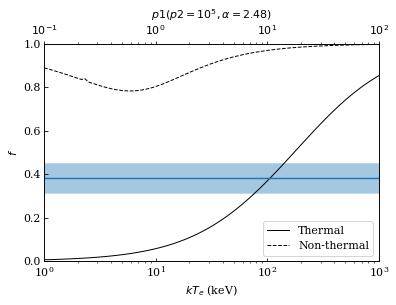

In [49]:
interp_vals = np.logspace(0,3, 100000)

non_thermal_interp = np.interp(interp_vals, Ts, 1-f_cr_arr_mustang)
def conv(x):
    #string = r'${:.0e}$'.format(int(x/1e1))
    num = int(np.log10(x/10))
    string = r'$10^{'+str(num)+'}$'
    return string

import matplotlib
matplotlib.rc('font',**{'family':'serif','sans-serif':['Times'],'size':11})
plt.rc('font',family='serif',size=11)
fullpage = False


dpi = 72.27*390.00/504.00

factory = 0.50
factorx = 1.00 if fullpage else 0.50
figsize = (factorx*504.00/dpi,factory*504.00/dpi)

fig, ax = plt.subplots()
plt.plot(Ts, 1-f_th_arr_mustang, "k", lw=1, label="Thermal")
plt.plot(interp_vals, non_thermal_interp, '--k', lw=1, label='Non-thermal')

ax.legend()
ax.tick_params(direction='in')
ax.set_xlabel(r"$kT_e$ (keV)"), ax.set_ylabel(r"$f$")
ax.set_xlim(1,1e3), ax.set_ylim(0, 1), ax.set_xscale('log')

ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
props = dict(boxstyle='round',  alpha=0.2)


ax2 = ax.twiny()
ax2.set_xscale('log')
ax2.set_xticks( ax.get_xticks() )
ax2.set_xbound(ax.get_xbound())
ax2.set_xticklabels([conv(x) for x in ax.get_xticks()])
ax2.set_xlabel(r'$p1 (p2 = 10^5, \alpha = 2.48)$')


xs = np.logspace(-2,4,10000)
ax.plot(xs, np.ones(len(xs))*0.38)
ax.fill_between(xs, 0.31,0.45, alpha = 0.4)

plt.savefig('f_280_plot.pdf')
#plt.savefig('./plots/herschel/v0_fixed_greybody_for_paper.png', dpi = 300)
plt.show()

# f_cr j(x)

In [232]:
#Analytic expression for KT
kT_cr_temp = np.zeros(len(ps))
for i, p1 in enumerate(ps):
    kT_cr_temp[i] = kT_cr(p1=ps[i], p2=1e5, alpha =2.5)

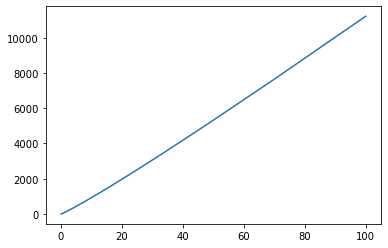

In [233]:
plt.plot(ps, kT_cr_temp)

In [54]:
#Replicating fig 7 in Colafrancesco2003
xs = np.linspace(0.01,20,100)
y = np.zeros(len(xs))
for i, x in enumerate(xs):
    y[i] = gTilde(x,f_cr, p1 = 4, p2 = 1e5, alpha = 2.5)*meKeV/kT_cr(p1=4, p2=1e5, alpha =2.5)


<ipython-input-53-85887fc90c5a>:45: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)
/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


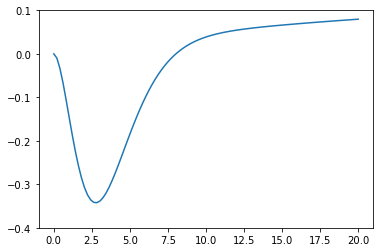

In [56]:
y2 = gSZtilde(xs,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
xs = np.linspace(0.01,20,100)

plt.ylim(-0.4,0.1)
plt.plot(xs, y, label = 'g_cr')

#plt.plot(xs, y2, label = 'g')

# Fig 8 in Colafrancesco2003

In [51]:
p1s = [0.5, 1, 10]
xs = np.linspace(0.01, 20, 50)

y_05 = np.zeros(len(xs))
y_1 = np.zeros(len(xs))
y_10 = np.zeros(len(xs))

kT_05 = kT_cr(p1=0.5, p2=1e10, alpha =2.5)
kT_1 = kT_cr(p1=1, p2=1e10, alpha =2.5)
kT_10 = kT_cr(p1=10, p2=1e10, alpha =2.5)

for i, x in enumerate(xs):
    y_05[i] = gTilde(x,f_cr, p1 = 0.5, p2 = 1e10, alpha = 2.5)*meKeV/kT_05
    y_1[i] = gTilde(x,f_cr, p1 = 1, p2 = 1e10, alpha = 2.5)*meKeV/kT_1
    y_10[i] = gTilde(x,f_cr, p1 = 10, p2 = 1e10, alpha = 2.5)*meKeV/kT_10

NameError: name 's' is not defined

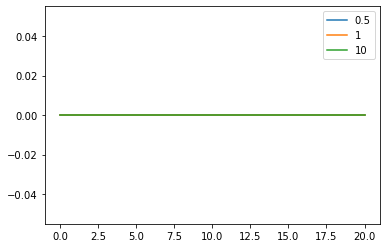

In [52]:
adjust_factor = 1
xs = np.linspace(0.01, 20, 50)

plt.plot(xs, y_05/adjust_factor, label = '0.5')
plt.plot(xs, y_1/adjust_factor, label = '1')
plt.plot(xs, y_10/adjust_factor, label = '10')
plt.legend()
plt.show()

In [270]:
kT_05


30.367770936964405

In [287]:
print(gTilde(0.6,f_cr, p1 = ps[i], p2 = 1e10, alpha = 2.5))
print(gTilde(1.5,f_cr, p1 = ps[i], p2 = 1e10, alpha = 2.5))

-0.26271661929978735
-0.9692893433593011


In [288]:
print(gSZtilde(0.6,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'))
print(gSZtilde(1.5,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'))

-0.677944527932168
-3.0664315688029404


In [5]:
x = 0.5284*90/30

print(gSZtilde(x,Te=5.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'))
print(gSZtilde(x,Te=50.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'))

/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
<ipython-input-3-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)
/local/jupyter2021/lib/python3.8/site-packages/scipy/integrate/quadpack.py:880: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the s

-3.1737974988188817
-2.519341073939031


In [289]:
print(gTilde(0.6,f_cr, p1 = ps[i], p2 = 1e10, alpha = 2.5)/gSZtilde(0.6,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'))
print(gTilde(1.5,f_cr, p1 = ps[i], p2 = 1e10, alpha = 2.5)/gSZtilde(1.5,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal'))

0.38751934483653444
0.3160968446909408


In [92]:
x = 0.5284*90/30

g = gSZtilde(x,Te=0.0,p1=1.,p2=1.e3,alpha=2.,etype='thermal')
#f_cr_arr_mustang = gTilde(x,f_cr, p1 = 0.01, p2 = 1e10, alpha = 2.5)*meKeV/kT_cr(p1=0.01, p2=1e10, alpha =2.5)/g
f_th_arr_mustang = gSZtilde(x,Te=750,p1=1.,p2=1.e3,alpha=2.,etype='thermal')/g

<ipython-input-80-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


In [75]:
for Te in range(100, 1000, 25):
    f_th_arr_mustang = gSZtilde(x,Te=Te,p1=1.,p2=1.e3,alpha=2.,etype='thermal')/g

    print(Te, 1-f_th_arr_mustang)

<ipython-input-4-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


100 0.3687697199312636
125 0.4203474655213335
150 0.4639624174148287
175 0.5014148097815807
200 0.5339754845772331
225 0.5625735208893268
250 0.5879078711200603
275 0.6105165016818908
300 0.6308221954511548
325 0.6491624253676938
350 0.6658105112741771
375 0.6809905015544264
400 0.6948880435760381
425 0.7076584437475255
450 0.7194326822294759
475 0.7303221222004035
500 0.7404220397529295
525 0.7498144351730245
550 0.7585703608763442
575 0.7667516684805451
600 0.7744124403298236
625 0.7816002635853954
650 0.7883570381261626
675 0.7947199021094191
700 0.8007218672315934
725 0.8063923707437677
750 0.811757760556722
775 0.8168416740214679
800 0.8216653836770671
825 0.8262480919230659
850 0.8306071579278873
875 0.8347583471557982
900 0.8387159664668566
925 0.8424930594211256
950 0.8461015277111457
975 0.849552261697134


In [93]:
for Te in range(5, 150, 5):
    f_th_arr_mustang = gSZtilde(x,Te=Te,p1=1.,p2=1.e3,alpha=2.,etype='thermal')/g

    print(Te, 1-f_th_arr_mustang)

<ipython-input-80-4090ffb2c66c>:47: RuntimeWarning: overflow encountered in exp
  return (x**3.)/(np.exp(x)-1.)


5 0.02945484252412578
10 0.05718094260255324
15 0.08327841194769081
20 0.1078605337541495
25 0.13104233195371384
30 0.15293530158870372
35 0.17364401371525806
40 0.19326505271457117
45 0.21188624135955836
50 0.2295871805773545
55 0.24643963911225242
60 0.2625082830588913
65 0.27785134818237167
70 0.29252128596448257
75 0.30656553708648937
80 0.32002686065168984
85 0.3329443198998542
90 0.3453529859469959
95 0.35728500826765996
100 0.3687697199312636
105 0.37983390855486987
110 0.3905020965278835
115 0.40079685850528135
120 0.41073893592189825
125 0.4203474655213335
130 0.429640231209774
135 0.43863335378585544
140 0.44734224353072605
145 0.4557808868848474


# F-Test

In [49]:
#Following is all for r1 r3 no pred, fixed beta

chi_sq_iso_only = 1131092765.3367472-6677813.358072758
chi_sq_bubb = 1130761031.8036547 -6346203.750791311-11.091

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

8.424076543089827


In [50]:
#Following is all for r2 r3 no pred, fixed beta

chi_sq_iso_only = 1128758473.312426-4343487.761574745
chi_sq_bubb = 1128562361.0090246 -4147488.1220293045-10.24604082107544


n_samp = 1181988681


f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

8.0375150536842


In [51]:
#Following is all for r1 r3 pred, fixed beta

chi_sq_iso_only = 1131270619.2507377-6835836.720794916
chi_sq_bubb = 1130926830.337863 -6492130.553176403-7.478976488113403

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

6.886303213348964


In [53]:
chi_sq_bubb/n_samp

0.9513075478234466

In [52]:
#Following is all for r2 r3 pred, fixed beta

chi_sq_iso_only = 1128865911.657925-4431078.294019699
chi_sq_bubb = 1128661221.2821429 -4226464.179534912-3.4254279136657715

n_samp = (1181988681)

f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

6.471687235460311


In [3]:
#Following is all for r1 r3 pred, fit beta

chi_sq_iso_only = 1129308420.5603561 - 4873736.043519974 -5.7 - 3.0-.8-.9-.3-.3-.3
chi_sq_bubb = 1128953328.0242002 -4518740.682882786-50.403496742248535 -2.5

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

8.540562485034565


In [5]:
#Following is all for r1 r3 no pred, fit beta

chi_sq_iso_only = 1129178750.469703 - 4763745.488110304   -63.068015336990356 - 3.3131392002105713 -0.7 -0.2
chi_sq_bubb = 1128833532.917975 -4418695.678370476-33.583003520965576 -16.95491933822632  - 1

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

8.938165759792744


In [4]:
#Following is all for r2 r3 pred, fit beta

chi_sq_iso_only = 1127182802.824991 -2748099.3436656 -17.610564947128296  - 2.901209831237793 -1-1-.4-.3-.2-.2
chi_sq_bubb = 1126959081.1383693 -2524480.4604451656-58.62015724182129 -3

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

8.602884100454704


In [6]:
#Following is all for r2 r3 no pred, fit beta

chi_sq_iso_only = 1127107078.4216986 - 2692088.9746305943 -14.327225685119629  - 25.99054741859436-1.3
chi_sq_bubb = 1126890161.5221534 -2475344.702363491 -18.372250080108643 -3.633660316467285 -0.8

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb)/(2-0))/(chi_sq_bubb/n_samp)

print(np.sqrt(f_stat))

8.991420667795522
The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.


In [24]:
#Following is all for r1 r3 pred, fit beta vs fixed beta

chi_sq_fixed_beta = 1130926830.337863 -6492130.553176403-7.478976488113403
chi_sq_fit_beta = 1128919000.8838043 -4484416.091416359-56.418808937072754 -2.5

n_samp = 1181988681

f_stat = ((chi_sq_fixed_beta-chi_sq_fit_beta)/(1-0))/(chi_sq_fit_beta/n_samp)

print(np.sqrt(f_stat))

13.226902729650877


In [25]:
#Following is all for r1 r3 no pred, fit beta vs fixed beta

chi_sq_fixed_beta = 1130761031.8036547 -6346203.750791311-11.091
chi_sq_fit_beta = 1128799923.8946788 -4385098.660462618-36.489582538604736 -13.642634391784668  - 0.6

n_samp = 1181988681

f_stat = ((chi_sq_fixed_beta-chi_sq_fit_beta)/(1-0))/(chi_sq_fit_beta/n_samp)

print(np.sqrt(f_stat))

6.680864844649381


In [26]:
#Following is all for r2 r3 pred, fit beta vs fixed beta

chi_sq_fixed_beta = 1128661221.2821429 -4226464.179534912-3.4254279136657715
chi_sq_fit_beta = 1126935942.8775017 -2501344.8784291744-64.13170886039734 -2

n_samp = 1181988681

f_stat = ((chi_sq_fixed_beta-chi_sq_fit_beta)/(1-0))/(chi_sq_fit_beta/n_samp)

print(np.sqrt(f_stat))

15.269680593362072


In [7]:
#Following is all for r2 r3 no pred, fit beta vs fixed beta

chi_sq_fixed_beta = 1128562361.0090246 -4147488.1220293045-10.24604082107544
chi_sq_fit_beta = 1126890161.5221534 -2475344.702363491 -18.372250080108643 -3.633660316467285 -0.8

n_samp = 1181988681

f_stat = ((chi_sq_fixed_beta-chi_sq_fit_beta)/(1-0))/(chi_sq_fit_beta/n_samp)

print(np.sqrt(f_stat))

8.493586765642277


In [9]:
#Following is all for r2 r3 pred, fixed beta, shock v no shock

chi_sq_no_shock = 1128661221.2821429 -4226464.179534912-3.4254279136657715
chi_sq_shock = 1124466942.8687546 -32210.71926522255-119.12240242958069-17.815516233444214-0.18976283073425293 

n_samp = 1181988681

f_stat = ((chi_sq_no_shock-chi_sq_shock)/(1-0))/(chi_sq_shock/n_samp)

print(np.sqrt(f_stat))

12.914183420950867


## shock+bub vs isobeta only

In [3]:
#Following is all for r1 r3 no pred, fixed beta

chi_sq_iso_only = 1131092765.3367472-6677813.358072758
chi_sq_bubb_shock = 1124469575.3562646 -54671.09308171272 -89.49309229850769-1.1983990669250488-0.5

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb_shock)/(3-0))/(chi_sq_bubb_shock/n_samp)

print(np.sqrt(f_stat))

6.976615547872769


In [4]:
#Following is all for r2 r3 no pred, fixed beta

chi_sq_iso_only = 1128758473.312426-4343487.761574745
chi_sq_bubb_shock = 1124443439.4435515 -28568.51579284668-27.860928535461426-1.5


n_samp = 1181988681


f_stat = ((chi_sq_iso_only-chi_sq_bubb_shock)/(3-0))/(chi_sq_bubb_shock/n_samp)

print(np.sqrt(f_stat))

7.1029686191162575


In [5]:
#Following is all for r1 r3 pred, fixed beta

chi_sq_iso_only = 1131270619.2507377-6835836.720794916
chi_sq_bubb_shock = 1124494701.89577 -60016.632252693176-82.95947289466858-11.59190845489502  -1

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb_shock)/(3-0))/(chi_sq_bubb_shock/n_samp)

print(np.sqrt(f_stat))

8.219634423706124


In [6]:
#Following is all for r2 r3 pred, fixed beta

chi_sq_iso_only = 1128865911.657925-4431078.294019699
chi_sq_bubb_shock = 1124466942.8687546-32210.71926522255-119.12240242958069-17.815516233444214-1

n_samp = 1181988681

f_stat = ((chi_sq_iso_only-chi_sq_bubb_shock)/(3-0))/(chi_sq_bubb_shock/n_samp)

print(np.sqrt(f_stat))

9.154112479555977


## Shock vs. no shock, both with bub

In [7]:
#Following is all for r2 r3 pred, fixed beta, shock v no shock

chi_sq_no_shock = 1128661221.2821429 -4226464.179534912-3.4254279136657715
chi_sq_shock = 1124466942.8687546 -32210.71926522255-119.12240242958069-17.815516233444214-0.18976283073425293 

n_samp = 1181988681

f_stat = ((chi_sq_no_shock-chi_sq_shock)/(1-0))/(chi_sq_shock/n_samp)

print(np.sqrt(f_stat))

12.914183420950867


In [8]:
#Following is all for r2 r3 no pred, fixed beta, shock v no shock

chi_sq_no_shock = 1128562361.0090246 -4147488.1220293045-10.24604082107544
chi_sq_shock  = 1124443439.4435515 -28568.51579284668-27.860928535461426-1.5


n_samp = 1181988681

f_stat = ((chi_sq_no_shock-chi_sq_shock)/(1-0))/(chi_sq_shock/n_samp)

print(np.sqrt(f_stat))

4.706717615757639


In [10]:
#Following is all for r1 r3 pred, fit beta vs fixed beta, shock v no shock

chi_sq_no_shock = 1130926830.337863 -6492130.553176403-7.478976488113403
chi_sq_shock = 1124494701.89577-60016.632252693176 -82.95947289466858 -11.59190845489502 -1

n_samp = 1181988681

f_stat = ((chi_sq_no_shock-chi_sq_shock)/(1-0))/(chi_sq_shock/n_samp)

print(np.sqrt(f_stat))

10.384835946337065


In [11]:
#Following is all for r1 r3 no pred, fit beta vs fixed beta, shock v no shock

chi_sq_no_shock = 1130761031.8036547 -6346203.750791311-11.091
chi_sq_shock = 1124469575.3562646 -54671.09308171272-89.49309229850769 -1.1983990669250488 -0.5

n_samp = 1181988681

f_stat = ((chi_sq_no_shock-chi_sq_shock)/(1-0))/(chi_sq_shock/n_samp)

print(np.sqrt(f_stat))

2.022217053075111


36081.16639653379


In [31]:
factor

nan